# Keras - custom training loop

Refs:
* https://keras.io/api/models/model/
* https://twitter.com/fchollet/status/1280733141980680193

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

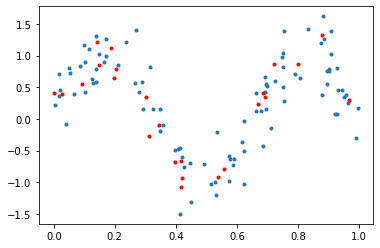

In [2]:
# Cook some simplistic data:
np.random.seed(1)
n_points = 120
x = np.random.uniform(size=n_points)
y = np.sin(x*3*np.pi) + np.random.normal(size=x.shape)/3

ind = list(range(np.round(n_points*0.2).astype(int)))
xtest = x[ind]
ytest = y[ind]
x = x[[i for i in range(n_points) if i not in ind ]]
y = y[[i for i in range(n_points) if i not in ind ]]

plt.plot(x,y,'.');
plt.plot(xtest, ytest, 'r.');

In [3]:
# Custom callback, to see what's happening during the training
# https://www.tensorflow.org/guide/keras/custom_callback

class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            print(f"{logs['loss']:0.3}", end=' ')

In [32]:
# inputs: Tensor("IteratorGetNext:0", shape=(16,), dtype=float32)
# outputs: Tensor("IteratorGetNext:1", shape=(16,), dtype=float32)

class CustomModel(tf.keras.Sequential):
    """By inheriting to this model, we can keep all init params exactly as they were."""
    
    def train_step(self, data):
        inputs, outputs = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            print(predictions)
            loss = self.compiled_loss(outputs, predictions)
            
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        self.compiled_metrics.update_state(outputs, predictions)
        return {m.name: m.result() for m in self.metrics}

In [37]:
def make_model(learning_rate=0.002):
    # Let's build a model of leakyReLU units, so that we could have layer width==1, and still have gradients.
    # This woudl be useful for testing different shapes.
    # LeakyReLU cannot be set as a layer activation, it appears, but can be a separate layer.
    model = CustomModel([
        tf.keras.layers.Input(shape=(1,)), # https://www.tensorflow.org/api_docs/python/tf/keras/Input
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=['mean_squared_error']
                 )
    return model

model = make_model()
model.summary()

Model: "custom_model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_31 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Fit
history = model.fit(x, y,
                    #batch_size=16,
                    epochs=100,
                    verbose=0
                    #, validation_data=(xtest, ytest) # Keeping this commented makes everything faster
                   )

ValueError: in user code:

    C:\Users\khakh\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-32-cd43f1df2f9e>:10 train_step  *
        predictions = self(inputs, training=True)
    C:\Users\khakh\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__  **
        self.name)
    C:\Users\khakh\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer custom_model_7 is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: [32]


In [12]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history['loss']);
#plt.plot(history.history['val_loss']);
    
plt.subplot(122)
y_new = model.predict(x)
plt.plot(x,y, '.');
ind = np.argsort(x)
plt.plot(x[ind], y_new[ind], 'r-');

ValueError: in user code:

    C:\Users\khakh\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-10-8618e612de42>:7 train_step  *
        predictions = self(inputs, training=True)
    C:\Users\khakh\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__  **
        self.name)
    C:\Users\khakh\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer custom_model_1 is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: [16]
